# Introduction
In this lab we will investigate LHC data from 8 TeV collisions. These samples were produced in a fun experiment 4 years ago. The studies done then have led to wealth of results from both the LHC experiments. Since it opened up the option of performing low mass resonance options. To understand how this works, we need to introduce a few concepts. Lets first consider the process that we would like to look for. Here is a feynman diagram of the process. 
<img src="images/Wqq.png" width="300"/>
What does this mean. At the top the W boson is decaying. It can decay to many things. The full list of W boson decays is [here](http://pdg.lbl.gov/2012/listings/rpp2012-list-w-boson.pdf) in the section on W branching ratios. The quark label generically means that the W boson decays to all decays with quarks. In the document this is equivalent to hadrons. At the bottom you have a gluon. 

Both quarks and gluons that are high energy decay into objects that we refer to as jets. A jet is collection of particles coming from an original quark or gluon. I will not explain the details of a jet instead I will point you to summer school lectures I gave on this [here](https://indico.fnal.gov/event/11505/session/30/?slotId=0#20160820) (start from slide 36). 

So this problem becomes interesting when the W boson has a high energy, or in other words its boosted. In this case the decays of the W are restricted to within a cone. A simple calculation  <font color='red'> of special relativity that you should do </font> will give you the maximum angular separation $\Delta \theta$ can be described by 
\begin{eqnarray}
\Delta \theta & < & \frac{2m}{p}
\end{eqnarray}
Where $m$ is the mass of the resonance decyaing and $p$ is the momentum of the boson. Thus, by taking $p$ to be sufficiently high the angle $\theta$ is sufficiently small that we can resolve these as a cone. We will still take a large cone with $\Delta \theta_{max} = 0.8$. A small point about collisions at the LHC is that in place of momentum we often use a variable called transverse momentum or $\vec{p}_{T}$. What this is the projection of $\vec{p}$ onto the plane perpendicular to the collision. This plane is particularly well uncerstood since by transverse momentum consevation all collisions need to have $\sum_{i} \vec{p_{T}}^{i}=0$ for all resulting particles in the collision. For this analysis, you can effetively interchange them. 

Now once we have a cone sufficient to detect both quarks. We need to find a jet with two quarks. To find a jet with two quarks we need to remove our background processes. Our main background process consists of the diagrams below
<img src="images/dijet.png" width="600"/>
There are additional processes that produce a final state quark and gluon as well. These process will consist of two jets recoiling against each other and these jets are quarks or gluons.  The point being is that our main background consists of either a quark or a gluon and our signal is a boson with 2 quarks inside. So the challenge is to construct an identification of a jet that looks like it came from two quarks. 

# Loading data & Auxiliary functions

Now is a good time to look at the data. Lets take a look at the differen samples we have. The data can be downloaded from this link [here (3 GB)](https://www.dropbox.com/s/bcyab2lljie72aj/data.tgz?dl=0)

One more thing before we look at the data, lets define collider coordinates. You can just readn this short link [here](https://www.lhc-closer.es/taking_a_closer_look_at_lhc/0.momentum). The point being is that we tend to write our momentum 4 vector as $\vec{p}=(p_{T},\eta,\phi,m)$ in place of $\vec{p}=(p,\theta,\phi,m)$.

In [1]:
#prequisites
#uproot High energy physics python file format => https://masonproffitt.github.io/uproot-tutorial/aio.html
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os,sys
#plotting style for High Energy physics 
import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
#Now lets look at the data. Our data sample is the JetHT dataset. 
#What that means is the data passed triggers that have a jet in one of the triggers. (discuss below)
data   = uproot.open("data/JetHT_s.root")["Tree"]

#In addition to above we have Monte Carlo Simulation of many processes
#Some of these process are well modelled in simulation and some of them are not
#Now we have our actual process qq=>W=>qq at 8TeV collision energy
wqq    = uproot.open("data/WQQ_s.root")["Tree"]
#Now we have our actual process qq=>Z=>qq at 8TeV collision energy
zqq    = uproot.open("data/ZQQ_s.root")["Tree"]
#Unfortunately the samples I made above a long time ago are very small. 
#To train NNs and make nice plots we will use larger samples produced at a different collision energy
#qq=>W=>qq at 13TeV collision energy
wqq13  = uproot.open("data/skimh/WQQ_sh.root")["Tree"]
#qq=>Z=>qq at 13TeV collision energy
zqq13  = uproot.open("data/skimh/ZQQ_sh.root")["Tree"]
#Now we have our worst modeled background this is also our main background. 
#This is is our di-jet quark and gluon background. 
#We just call these backgrounds QCD because they are produced with Quantum chromo dynamics. 
qcd    = uproot.open("data/QCD_s.root")["Tree"]
#Now we have the Higgs boson sample (we might need this in the future)
ggh    = uproot.open("data/ggH.root")["Tree"]
#And top-quark pair production background. 
tt     = uproot.open("data/TT.root")["Tree"]
#Finally we have the rarer double W, W+Z and Z+Z diboson samples where we have two bosons instead of one
ww     = uproot.open("data/WW.root")["Tree"]
wz     = uproot.open("data/WZ.root")["Tree"]
zz     = uproot.open("data/ZZ.root")["Tree"]

In [3]:
#lets define some plotting functions and data manipulation
#build a histrogram from an uproot dataset
def getHist(iData,iMask,iVar,iBins,iMin,iMax,iWeights=None,scale=1):
    #make an array passing a selection (iMask)
    if iVar != 't21':
        data=iData.array(iVar)[iMask].flatten()
    else:
        #compute t2/t1 n-subjettiness (see below)
        data= iData.array('vjet0_t2')[iMask].flatten()/iData.array('vjet0_t1')[iMask].flatten()  
    #if the events are weighted compute their weights (see MC plots later)
    #Weights in this format are given by [number,variable name 1,variable name 2,...]; all are multiplied
    if iWeights != None: 
        #get weight and if additional scale multiply it
        weight     = iWeights[0]*scale
        for i0 in range(1,len(iWeights)):
            #get the weight array
            weightarr = iData.array(iWeights[i0])[iMask].flatten()
            #now systematically multiply
            weight    = weight*weightarr
        #make a histogram
        y,binEdges = np.histogram(data,bins=iBins,range=(iMin,iMax),weights=weight)
    else:
        #make a histogram sans weights
        y,binEdges = np.histogram(data,bins=iBins,range=(iMin,iMax))
    return y,binEdges

#build a histogram with errors
def histErr(iDatas,iMasks,iVar,iBins,iMin,iMax,iColor='',iFmt='o',iWeights=None,scale=[]):
    #build individual histograms for each data set, look over them and sum them
    for i0 in range(len(iDatas)):
        if i0 < len(scale):
            ytmp,binEdges=getHist(iDatas[i0],iMasks[i0],iVar,iBins,iMin,iMax,iWeights,scale[i0])
        else:
            ytmp,binEdges=getHist(iDatas[i0],iMasks[i0],iVar,iBins,iMin,iMax,iWeights)
        if i0==0:
            y=ytmp
        else:
            y=y+ytmp
    #now lets actually build the plot
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    #and lets apply poisson uncertainties
    menStd     = np.sqrt(y)
    #and lets put a dummy width for x
    width      = 0.005
    #plot filled for histograms
    if iWeights != None and iFmt=='h':
        #hist = plt.errorbar(bincenters,y,xerr=width,yerr=menStd,fillstyle='full')
        hist = plt.bar(binEdges[:-1],y,width=np.diff(binEdges), align="edge",color=iColor)
    else:
        hist = plt.errorbar(bincenters,y,xerr=width,yerr=menStd,fmt=iFmt,c=iColor,ecolor=iColor)
    return hist


In [4]:
#we can view all of these variables
wqq.keys()

[b'sample',
 b'run',
 b'lumi',
 b'event',
 b'trigger',
 b'hltmatch',
 b'puweight',
 b'npu',
 b'npuPlusOne',
 b'npuMinusOne',
 b'nvtx',
 b'metFiltersWord',
 b'scale1fb',
 b'rho',
 b'metRaw',
 b'metRawPhi',
 b'met',
 b'metphi',
 b'tkmet',
 b'tkmetphi',
 b'mvamet',
 b'mvametphi',
 b'puppet',
 b'puppetphi',
 b'mt',
 b'rawmt',
 b'tkmt',
 b'mvamt',
 b'puppetmt',
 b'metSig',
 b'mvaMetSig',
 b'njets',
 b'nbtags',
 b'nfwd',
 b'mindphi',
 b'j0_pt',
 b'j0_eta',
 b'j0_phi',
 b'j1_pt',
 b'j1_eta',
 b'j1_phi',
 b'j2_pt',
 b'j2_eta',
 b'j2_phi',
 b'j0_mass',
 b'j0_csv',
 b'j0_qgid',
 b'j0_chf',
 b'j0_nhf',
 b'j0_emf',
 b'j0_dphi',
 b'j1_mass',
 b'j1_csv',
 b'j1_qgid',
 b'j1_chf',
 b'j1_nhf',
 b'j1_emf',
 b'j1_dphi',
 b'j2_mass',
 b'j2_csv',
 b'j2_qgid',
 b'j2_chf',
 b'j2_nhf',
 b'j2_emf',
 b'j2_dphi',
 b'dj0_pt',
 b'dj0_mass',
 b'dj0_phi',
 b'dj0_y',
 b'dj0_qgid',
 b'dj0_csv',
 b'dj0_jdphi',
 b'nvjet',
 b'vjet0_pt',
 b'vjet0_eta',
 b'vjet0_phi',
 b'vjet0_mass',
 b'vjet0_csv',
 b'vjet0_flavor',
 b'vje

# Sample Composition
Now that we have loaded the data. Lets  look at the variables.  There are a lot of different variables, but most of them we will not use for this study. However, you should feel free to explore the different variables. For completeness, I will write a table of all of the different variables below: 

| sample   | book keeping variable | 
|------|------|
| run      | LHC run  period           |
| lumi     | LHC run period sub section | 
| event    | LHC collision id |
| trigger  | Bitmask of triggers that have been passed |  
| hltmatch | ??? (unused I think) | 
| puweight | Weight to match the beam inensity (so called Pileup) |
| npu      | For simulation the number of simulated pileup collisions | 
| npuPlusOne      | "" |
| npuMinusOne     | "" |
| nvtx            | Number of reconstructed vertices (a proxy for the total number of collisions) | 
| metFiltersWord  | Bitmask of whether event had anamalous detector features | 
| scale1fb        | The expected number of events per 1/fb of data | 
| rho             | energy density | 
| metRaw          | Raw Missing Transverse Energy (this is a proxy of the direction of invisible particles in the transverse plane | 
| metRawPhi       | Raw Missing Transverse Energy direction in transverse plane | 
| met             | Corrected metRaw | 
| metphi          | Correct metRawPhi | 
| tkmet           | charged metRaw | 
| tkmetphi        | charged metRawPhi | 
| mvamet          | ML  corrected metRaw |  
| mvametphi       | ML corrected metRawPhi | 
| puppet          | PUPPI corrected metRaw |
| puppetphi       | PUPPI corrected metRawPhi | 
| mt              | relativistic mass of (met+leading jet) in the transverse plane | 
| rawmt           | relativistic mass of (metRaw+leading jet) in the transverse plane | 
| tkmt            | relativistic mass of (tkmet+leading jet) in the transverse plane | 
| mvamt           | relativistic mass of (mvamet+leading jet) in the transverse plane | 
| puppetmt        | relativistic mass of (puppet+leading jet) in the transverse plane | 
| metSig          | probalbilistic measure missing transverse Energy is from 0 in sigma | 
| mvaMetSig       | probalbilistic mvamet is from 0 in sigma | 
| njets           | Number of jets with pt > 30 GeV | 
| nbtags          | Number of b-jets with pt > 30 GeV | 
| nfwd            | Number of jets with pt > 30 GeV and abs(eta) > 2.5 | 
| mindphi         | minimum direction in transverse plane of all jets and met | 
| j0_pt           | leading small jet pt | 
| j0_eta          | leading small jet $\eta$ | 
| j0_phi          | leading small jet $\phi$ | 
| j1_pt           | sub leading small jet pt | 
| j1_eta          | sub leading small jet $\eta$ | 
| j1_phi          | sub leading small jet $\phi$ | 
| j2_pt           | third highest leading small jet pt | 
| j2_eta          | third highest leading small jet $\eta$ | 
| j2_phi          | third leading small jet $\phi$ | 
| j0_mass         | leading jet mass | 
| j0_csv          | leading jet ML b-quark likelihood ML discriminator |
| j0_qgid         | leading jet quark vs gluon discrminator | 
| j0_chf          | leading jet charged particle fraction  |
| j0_nhf          | leading jet neutral (on photon) particle fraction  |
| j0_emf          | leading jet photon particle fraction  |
| j0_dphi         | ??? | 
| j1_mass         | subleading jet mass | 
| j1_csv          | subleading jet ML b-quark likelihood ML discriminator |
| j1_qgid         | subleading jet quark vs gluon discrminator | 
| j1_chf          | subleading jet charged particle fraction  |
| j1_nhf          | subleading jet neutral (on photon) particle fraction  |
| j1_emf          | subleading jet photon particle fraction  |
| j1_dphi         | ??? | 
| j2_mass         | third highest jet mass | 
| j2_csv          | third highest ML b-quark likelihood ML discriminator |
| j2_qgid         | third highest jet quark vs gluon discrminator | 
| j2_chf          | third highest jet charged particle fraction  |
| j2_nhf          | third highest jet neutral (on photon) particle fraction  |
| j2_emf          | third highest jet photon particle fraction  |
| j2_dphi         | ??? | 
| dj0_pt          | Lead and sub leading jets combined 4-vector pt  | 
| dj0_mass        | Lead and sub leading jets combined 4-vector mass | 
| dj0_phi         | Lead and sub leading jets combined 4-vector $phi$ | 
| dj0_y           | Lead and sub leading jets combined 4-vector rapidity | 
| dj0_qgid        | Lead and sub leading jets combined quark gluon| 
| dj0_csv         | Lead and sub leading jets combined b-quark discriminator | 
| dj0_jdphi       | Lead and sub leading jets difference in transverse plane | 
| nvjet           | number of fat jets | 
| vjet0_pt        | fat jet pt | 
| vjet0_eta       | fat jet $\eta$ | 
| vjet0_phi       | fat jet $\phi$ | 
| vjet0_mass      | fat jet mass | 
| vjet0_csv       | fat jet b-tag probability | 
| vjet0_flavor    | fat jet flavor id (if simulation) | 
| vjet0_t1        | fat jet $\tau_{1}$ | 
| vjet0_t2        | fat jet $\tau_{2}$ | 
| vjet0_t3        | fat jet $\tau_{3}$ | 
| vjet0_msd0      | fat jet soft drop mass $\beta=0$ |
| vjet0_msd1      | fat jet soft drop mass $\beta=1$ |
| vjet0_mprune    | fat jet pruned mass |
| vjet0_mtrim     | fat jet pruned mass |
| vjet0_pullAngle | fat jet color flow variable between quarks |
| vjet0_sj1_csv   | fat jet highest momentum subjet b-tag ML discriminator | 
| vjet0_sj2_csv   | fat jet subleading momentum subjet b-tag ML discriminator | 
| vjet0_sj1_qgid  | fat jet highest momentum subjet quark gluon likelihood | 
| vjet0_sj2_qgid  | fat jet subleading momentum subjet quark gluon likelihood | 
| vjet0_sj1_q     | fat jet highest momentum subjet charge  | 
| vjet0_sj2_q     | fat jet highest momentum subjet charge  | 
| vjet0_sj1_z     | fat jet highest momentum subjet energy relative to fat jet  | 
| vjet0_sj2_z     | fat jet subleading momentum subjet energy relative to fat jet  | 
| vjet0_iso15     | fat jet isolation with 1.5 cone | 
| vjet0_c2b0      | fat jet  $C_{2}^{\beta=0}$ correlation function for two likelihood |  
| vjet0_c2b0P2    | fat jet $C_{2}^{\beta=0.2}$ correlation function for two likelihood |  
| vjet0_c2b0P5    | fat jet $C_{2}^{\beta=0.5}$ correlation function for two likelihood |  
| vjet0_c2b1P0    | fat jet $C_{2}^{\beta=1.0}$ correlation function for two likelihood |  
| vjet0_c2b2P0    | fat jet $C_{2}^{\beta=2.0}$ correlation function for two likelihood |  
| vjet0_qjet      | fat jet quantum jet volatility |  
| vjet0_trig      | fat jet trigger matched | 
| vjet0_genm      | fat jet simulated mass (if matched to a jet) |
| vjet0_genV      | ??? |
| nmuons          | number of muons | 
| mu0_pt          | Leading Muon  pt | 
| mu0_eta         | Leading Muon $\eta$ | 
| mu0_phi         | Leading Muon $\phi$ | 
| dm0_pt          | dimuon combined 4-vector pt | 
| dm0_mass        | dimuon combined 4-vector relativistic mass | 
| dm0_phi         | dimuon combined 4-vector $\phi$ | 
| dm0_y           | dimuon combined 4-vector rapidity | 
| nelectrons      | number of electrons | 
| e0_pt           | leading electron pt | 
| e0_eta          | leading electron $\eta$ |  
| e0_phi          | leading electron $\phi$ |
| ntaus           | number of hadronic $\tau_{h}$ | 
| tau0_pt         | leading $\tau_{h}$ $p_{T}$ |
| tau0_eta        | leading $\tau_{h}$ $\eta$ |
| tau0_phi        | leading $\tau_{h}$ $\phi$ |
| nphotons        | number of additional photons | 
| pho0_pt         | leading photon $p_{T}$ |
| pho0_eta        | leading photon $\eta$ |
| pho0_phi        | leading photon $\phi$ |

Now all of these variables are not needed. What we will focus on is the selection of what we call fat jets. The labels there given by vjet. Fat jets are large cone jets that are reconstructed with a large radius $\Delta\theta$ to ensure that both quarks are in the cone. To isolate a single collision we also are applying the PUPPI algorithm (you can ask me about this). You should focus on the vjet variables for this project. 

# Event Selection

Before we get there, lets talk about how we perform the selection of events. The dataflow at the LHC is complicated, but we can simplify it to the following diagram. Here I show it for ATLAS, but for CMS its basically the same. 

<img src="images/atlas-data-flow.png" width="1000"/>

If you look at right plot that is what we will make. The samples above are what we call ntuples, since they have n variables. The other thing we care about on this diagram is the how the data comes from the detector this is the top part call "trigger and DAQ" (DAQ = Data Acquisition). What the trigger does is look at the features of the event in a fast way to see if the event is interesting. If the event is interesting we keep it. If it is not, we throw it away. Triggers can be quite complicated because they have to process a lot of data. The first layer of the trigger takes in data at a rate of 20 MHz (Now its 40 MHz). This translates to about 50 terabits/s, which is the most amount of data in any single system. To process the data quickly, we use specialized FPGAs to look at the data quickly and determine if its interesting. Because we can only take a cursory look at the data, we sometimes make a mistake. This means that with the final reconstructed parameters the trigger will change. To understand how the trigger works lets plot some data. 

Now before we look at the data. Lets just make some quick plotting functions. See the comments on how it works, but it should be pretty straightforward. 


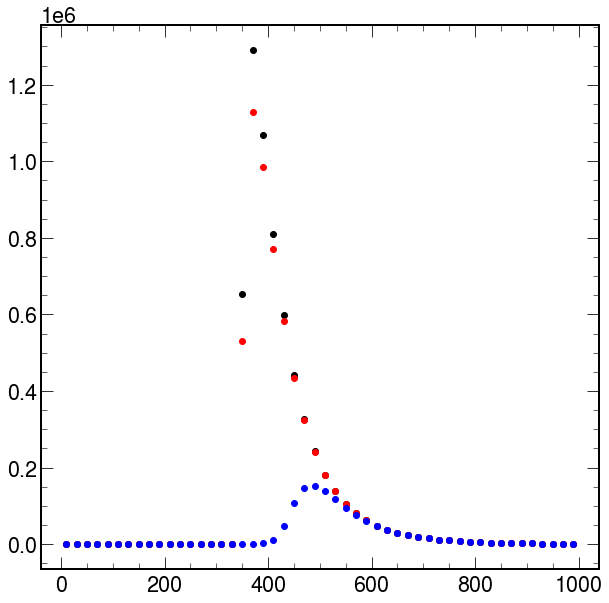

In [5]:
#Lets select some data (not trigger can only be > 0)
alldata      = (data.array('trigger').flatten() >= -1000000)
triggerdata1 = (data.array('trigger').flatten() % 2 > 0) #lets require the lowest trigger jet pt > 320
triggerdata2 = (data.array('trigger').flatten() % 4 > 1) #lets require one of our standard triggers (jet PT > 370 )
#now lets make a plot of the fat jet pt   
datahistnot     = histErr([data],[alldata]    ,"vjet0_pt",50,0,1000,'black')
datahistt1      = histErr([data],[triggerdata1],"vjet0_pt",50,0,1000,'red')
datahistt2      = histErr([data],[triggerdata2],"vjet0_pt",50,0,1000,'blue')
#So you can see as you cut tighter youg et much less jets, but the data will be cleaner (I suggest triggerdata1)


In [161]:
#first lets define a selection function. We will keep it basic, but you will like have to modify it
#Given our discussion above lets make a simple selection function that applies trigger and a basic cut to avoid trigger effects.
def selection(iData):
        #lets apply a. trigger selection
        trigger = (iData.array('trigger').flatten() > 0)
        #Now lets require the jet pt to be above a threshold
        jetpt   = (iData.array('vjet0_pt').flatten() > 400)
        #Lets apply both jetpt and trigger at the same time
        allcuts = np.logical_and.reduce([trigger,jetpt])
        return allcuts
    
    
def selectionqq(iData):
        trigger = (iData.array('trigger').flatten() >= 0)
        jetpt   = (iData.array('vjet0_pt').flatten() >= 400)
        jetrhop = np.log(iData.array('vjet0_msd0').flatten()*iData.array('vjet0_msd0').flatten()/iData.array('vjet0_pt').flatten())
        t21=iData.array('vjet0_t2').flatten()/iData.array('vjet0_t1').flatten()  
        t21ddt=t21+0.07*jetrhop
        t21cut   = t21ddt < 0.5
        allcuts = np.logical_and.reduce([trigger,jetpt,t21cut])#,qgpcut])
        return allcuts

def selectionbb(iData):
        trigger = (iData.array('trigger').flatten() >= 0)
        jetpt   = (iData.array('vjet0_pt').flatten() >= 400)
        jetrhop = np.log(iData.array('vjet0_msd0').flatten()*iData.array('vjet0_msd0').flatten()/iData.array('vjet0_pt').flatten())
        t21=iData.array('vjet0_t2').flatten()/iData.array('vjet0_t1').flatten()  
        t21ddt=t21+0.05*jetrhop
        #looser t21 cut
        t21cut   = t21ddt < 0.6
        #ddb=np.maximum(iData.array("vjet0_sj1_csv").flatten(),iData.array("vjet0_sj2_csv").flatten())
        ddb=iData.array("vjet0_sj1_csv").flatten()+iData.array("vjet0_sj2_csv").flatten()
        ddbcut = ddb > 1.8
        allcuts = np.logical_and.reduce([trigger,jetpt,t21cut,ddbcut])#,qgpcut])
        return allcuts
    
#This computs the integral of weighted events assuming a selection given by the function selection(see below)
def integral(iData,iWeights):
    #perform a selection on the data (
    mask_sel=selection(iData)
    #now iterate over the weights not the weights are in the format of [number,variable name 1, variable name 2,...]
    weight  =iWeights[0]
    for i0 in range(1,len(iWeights)):
        weightarr = iData.array(iWeights[i0])[mask_sel].flatten()
        #multiply the weights
        weight    = weight*weightarr
    #now take the integral and return it
    return np.sum(weight)

#This computes the integral of two selections for two datasets labelled 8TeV and 13TeV, but really can be 1 and 2
#Then it returns the ratio of the integrals
def scale(iData8TeV,iData13TeV,iWeights):
    int_8TeV  = integral(iData8TeV,iWeights)
    int_13TeV = integral(iData13TeV,iWeights)
    print("Scale:",int_8TeV/int_13TeV,int_8TeV,int_13TeV)
    return int_8TeV/int_13TeV

Now we want to know how to separate two prong jets from one prong jets. There are a lot of variables here that can be used to identify these. To make this simple, I am just going to go over the most basic ones. That way you can get a feel for how to identify. Your challenge will be to explore how to do this. 

# Jet Substructure

Groomed Mass. Jet Grooming is a very powerful tool to clean up the resolution of the mass of jet. The idea is just like how you would groom a bush. The strategy is to take a jet and remove radiative gluons off of quarks. This suprious radiation can effectively broaden the mass of a jet. The way this is done is to iterate down the down and remove clusters of quarks and gluons that have low energy and are far away from the central axes of the quark/gluon. Practially speaking this removes radiation away from the original quark and gluon direction. The details of how this works has deep physical meaning, which I will not go through here. What you should take away is that this is an iterative algorithm that is approximate, not perfect, but helps. There are many grooming algorithms. The main ones that we use are trimming, pruning, filtering, and soft drop (with various beta parameters). Typically at the LHC we use soft drop with $\beta=0$. Lets look at how it affects our background (QCD) and our w to quarks signal. 

Before we do this, we have to quickly go over how we weight our simulation. We apply three weights. The weights can be written out as 
\begin{eqnarray}
w_{tot} & = & \rm{total data}\times\sigma\times w_{PU}
\end{eqnarray}
The total data is defined as the total ammount data in our sample. To compute this we quote our data in units of $fb^{-1}$. This is a "femto-barn" where a barn is $10^{-28}m^{2}$, a volume of area that rumour has it Enrico Fermi claimed was as big as a barn.  Our next unit is the cross section,$\sigma$, this is the cross section interadction in units of $fb$ sot hat it cancels with our total data "luminosity". Lastly, we apply a pileup weight,$w_{PU}$ to match the simulated beam intensity. This has an affect at modifying the simulation in a certain way.  

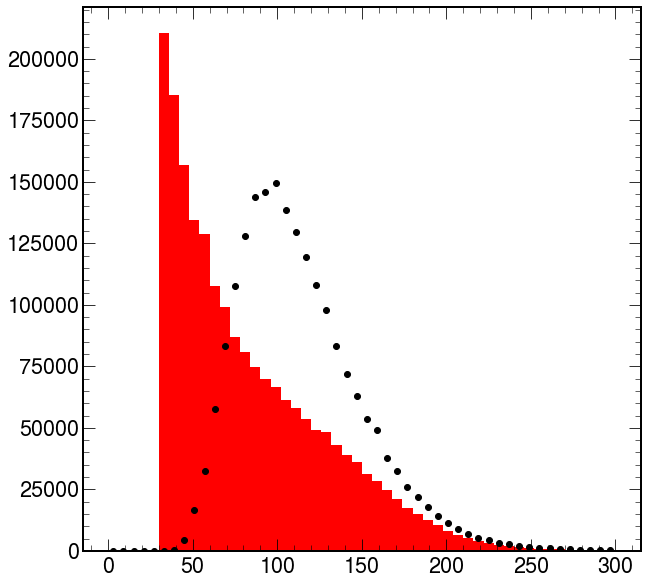

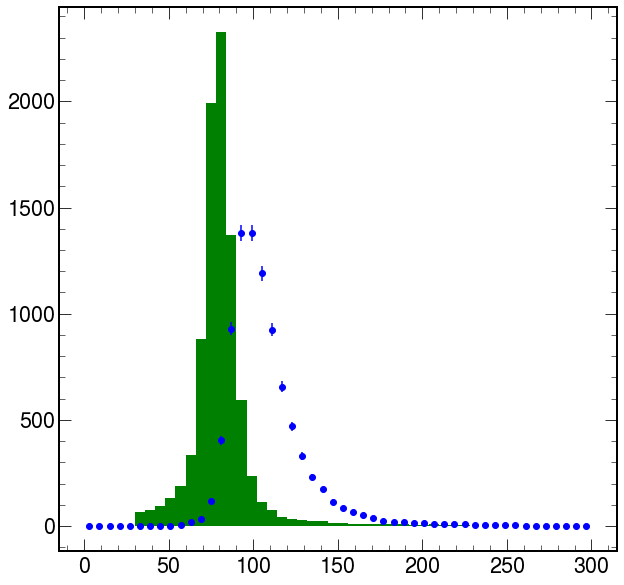

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


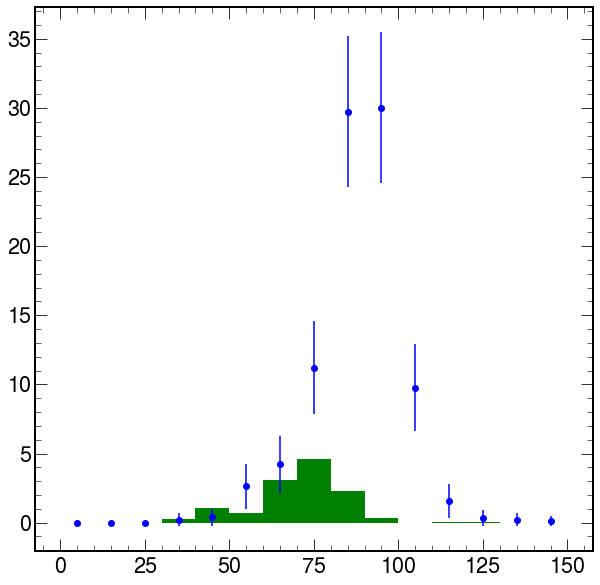

In [162]:
#first of all for MC, we need to apply some standard weights
weights=[1000*18300,"puweight","scale1fb"]

#Lets do a simple selection here is a trigger
qcdtrig       = (qcd.array('trigger').flatten() % 2 > 0)
#and to make things a little cleaner we can do a jet pt
qcdpt        = (qcd.array('vjet0_pt').flatten() > 400)
#now merge
qcdsel = np.logical_and.reduce([qcdtrig,qcdpt])

#now lets make a plot of the fat jet pt   
#def histErr(iDatas,iMasks,iVar,iBins,iMin,iMax,iColor='',iWeights=None,scale=[]):
qcdgmass        = histErr([qcd],[qcdsel],"vjet0_msd0",50,0,300,'red'  ,'h',weights)
qcdmass         = histErr([qcd],[qcdsel],"vjet0_mass",50,0,300,'black','o',weights)
plt.show()

#selection note we are going to use the larger wqq1 
wtrig       = (wqq13.array('trigger').flatten() % 2 > 0)
wpt         = (wqq13.array('vjet0_pt').flatten() > 400)
wsel        = np.logical_and.reduce([wtrig,wpt])
wgmass          = histErr([wqq13],[wsel]  ,"vjet0_msd0",50,0,300,'green','h',weights)
wmass           = histErr([wqq13],[wsel]  ,"vjet0_mass",50,0,300,'blue' ,'o',weights)
plt.show()

#selection note we are going to use the larger wqq1 
wtrig       = (wqq13.array('trigger').flatten() % 2 > 0)
wpt         = (wqq13.array('vjet0_pt').flatten() > 400)
wsel        = selectionbb(wqq13)

ztrig       = (zqq13.array('trigger').flatten() % 2 > 0)
zpt         = (zqq13.array('vjet0_pt').flatten() > 400)
zsel        = selectionbb(zqq13)

hsel        = selectionbb(ggh)

wcsv            = histErr([wqq13],[wsel]  ,"vjet0_msd0",15,0,150,'green','h',weights)
zcsv            = histErr([zqq13],[zsel]  ,"vjet0_msd0",15,0,150,'blue' ,'o',weights)
#hcsv            = histErr([ggh],[hsel]    ,"vjet0_sj1_csv",50,-1,2,'orange','o',weights)
plt.show()

What you observe is that the mass for our qcd background goes down to much lower values, and the mass for W boson gets more narrow and approaches the mass of the W boson (80.4 GeV).  This is a great way to reduce the background and improve the sensitivity of the signal. 

Now lets look at another class of variables. These variables are the n-subjettiness variables. These variables were developed at MIT by Prof. Thaler and a UROP. The original paper is [here](https://arxiv.org/abs/1011.2268). Each of these variables compute the likelihood of a certain number of prongs. Another way of saying hti sis the liklihood of a certain number of sub-jets in the shower. We write these variables as $\tau_{i}$ with $\tau_{1}$ being the likelihood for 1 pronged jet $\tau_{2}$ a two pronged and so on. To test these variables we use the ratios as a way to measure the likelihood of $N$ prongs vs $M$ prongs. To look for W and Z bosons, we look for 2 prongs with respect to one. Hence, we consider the variable $\tau_{2}/\tau_{1}$. 

Lets now look at how it compares between our simulation and and our background. 

Scale: 0.0044037121332298175 8759.844925946538 1989195.6288073258


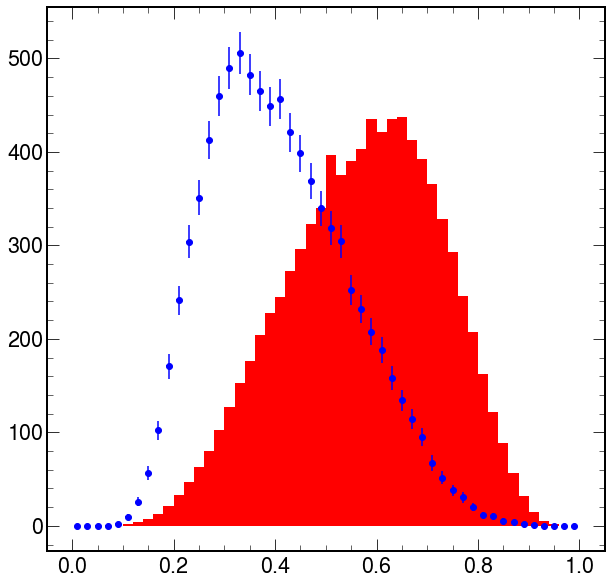

In [137]:
#Lets Look at the N subjettiness mass of QCD background compared to W 
#first of all for MC, we need to apply some standard weights
weights=[1000*18300,"puweight","scale1fb"]

#Lets do a simple selection here is a trigger
qcdtrig     = (qcd.array('trigger').flatten() % 2 > 0)
qcdpt       = (qcd.array('vjet0_pt').flatten() > 400)
qcdsel      = np.logical_and.reduce([qcdtrig,qcdpt])

#selection note we are going to use the larger wqq1 
wtrig       = (wqq13.array('trigger').flatten() % 2 > 0)
wpt         = (wqq13.array('vjet0_pt').flatten() > 400)
wsel        = np.logical_and.reduce([wtrig,wpt])

#Lets comput a scale factor of the two datasets so that we can get roughly the right size for our plots
wscale=scale(wqq13,qcd,weights)

#now lets make a plot of the fat jet pt   
qcdt21         = histErr([qcd],[qcdsel],"t21",50,0,1,'red'  ,'h',weights,[wscale])
wt21           = histErr([wqq13],[wsel]  ,"t21",50,0,1,'blue' ,'o',weights)
plt.show()

What you can see is that our two pronged signal has a lower $\tau_{2}/\tau_{1}$ the chance of the background is low. So by requiring $\tau_{2}/\tau_{1} < X$ we can isolate two pronged signals over the background. 

# Data vs Simulation

Now, lets try to find $W\rightarrow qq$ and $Z\rightarrow qq$ in the data. This is a difficult problem and you will have to use the above ideas plus a few others. To give you a hint you should read [this paper](https://arxiv.org/abs/1603.00027). Also, you should consider all of the other physics papers based on this strategy. That includes our [original paper](https://arxiv.org/abs/1705.10532) and two followup papers [here](https://arxiv.org/abs/1710.00159) and  [here](https://arxiv.org/abs/1909.04114). These later papers use more technology developed along the same lines, but the original paper should have all you need to get a resonance. 

To put it all together, we want to make a data vs simulation  plot. For this will take all of our simulations and add them together. Let's make a simple plotting example.

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


Scale: 1.6836067433254933 14748.133987809199 8759.844925946538
Scale: 0.6932541250123121 5663.988480165775 8170.147534376638


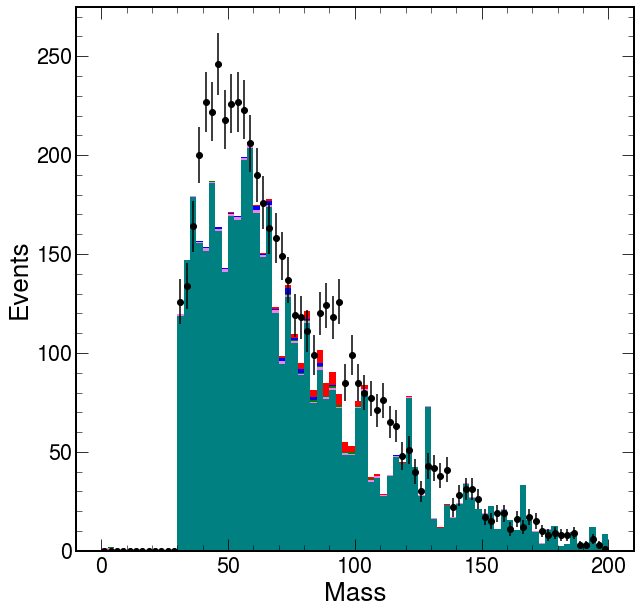

In [163]:
#Lets plot the mass
var="vjet0_msd0"
#pick a resonanble set of bins
nbins=80
#pick a range
minX=0
maxX=200

#Now we do weights
weights=[1000*18300,"puweight","scale1fb"]

#lets make the selection masks for all of our sim and data
data_sel=selectionbb(data)
wqq_sel=selectionbb(wqq13)
zqq_sel=selectionbb(zqq13)
qcd_sel=selectionbb(qcd)
tt_sel=selectionbb(tt)
ww_sel=selectionbb(ww)
wz_sel=selectionbb(wz)
zz_sel=selectionbb(zz)

#Now we have been using samples at different energy that have many more events
#Lets compute a scale we can correct our samples with
wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)

#finally, lets plot everything. We are going to build a stacked plot
zmchist   = histErr([zqq13,wqq13,ww,wz,zz,tt,qcd],[zqq_sel,wqq_sel,ww_sel,wz_sel,zz_sel,tt_sel,qcd_sel],var,nbins,minX,maxX,'red','h',weights,[zscale,wscale])
wmchist   = histErr([      wqq13,ww,wz,zz,tt,qcd],[        wqq_sel,ww_sel,wz_sel,zz_sel,tt_sel,qcd_sel],var,nbins,minX,maxX,'blue','h',weights,[wscale])
vvhist    = histErr([          ww,wz,zz,tt,qcd],[                ww_sel,wz_sel,zz_sel,tt_sel,qcd_sel],var,nbins,minX,maxX,'green','h',weights)
tthist    = histErr([tt,qcd],[tt_sel,qcd_sel] ,var,nbins,minX,maxX,'violet','h',weights)
qcdhist   = histErr([   qcd],[       qcd_sel] ,var,nbins,minX,maxX,'teal','h',weights)
datahist  = histErr([data],[data_sel],var,nbins,minX,maxX,'black')
plt.xlabel('Mass')
plt.ylabel('Events')
plt.show()


# The Lab
Now, lets do the lab. <font color="blue"> Your first challenge is to make a mass plot with the W and Z signal. </font>. The plot should look something like : 
<img src="images/vqq8tev.png" width='600'>
<font color="blue"> Next, setup a fit for the W and Z peak. Try to float the W boson and the Z boson mass </font>
You should aim for a plot that looks something like : 
<img src="images/bumpfit.png" width='600'>
<font color="blue"> Can you extract the W boson mass from your fit?  </font>


Now try to come up with a strategy to increase the ammount of Z boson events in your sample. To do this you will need to look at the decays of the W boson and the Z boson. Make sure to look at all the fat jet variables. Have a look [here for Z](http://pdg.lbl.gov/2018/listings/rpp2018-list-z-boson.pdf) and [here for W](http://pdg.lbl.gov/2018/listings/rpp2018-list-w-boson.pdf).  

<font color="blue">  With your strategy to isolate Z bosons make a selecton that has more Z bosons than W bosons. Remember it will not be possible for you to get rid of the W bosons or the background.  With this new cateogry run your fitting code. </font>


<font color="blue"> Can you extract the W and Z boson mass from your two category fit?  </font>
If you have both W and Z boson, you can measure a fundamental parameter of the standard model. The Weak mixing angle, sometimes referred to as the Weinberg angle. 


<font color="blue"> From your measurement of the W and Z boson mass come up with a measurement of the W and Z boson mixing angle.  </font>

Now if you have made it through this whole exercise, why don't you try to look for the Higgs boson. The Higgs boson also decays hadronically and decays predominantly to a certainy pair of particles. Take a look [here](http://pdg.lbl.gov/2019/reviews/rpp2019-rev-higgs-boson.pdf). 
 <font color="blue"> Can you search for the Higgs boson? What is your sensitivity.  </font>
